In [1]:
"""
The aim of this script is to create avaluate the performance of the multi-tissue model.
"""

In [ ]:

import time
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
import multiprocessing as mp
from time import gmtime, strftime


In [2]:
"---------------------------- Load Data -----------------------"
startTime = time.time() 
path = os.path.join('..', '..', 'Data', 'Transfer_Learning_Data_hg37.csv')
All_tissues_data= pd.read_csv(path)

path = os.path.join('..', '..', 'Data', 'Transfer_Learninig_Relevant_Columns_Names_Edited.csv')
Relevant_Cols_df = pd.read_csv(path)
overlap_cols = Relevant_Cols_df['Feature'].tolist()


In [3]:
rename_dict = dict(zip(overlap_cols, Relevant_Cols_df['Feature Name'].tolist()))
# print(rename_dict)
All_tissues_data.rename(columns=rename_dict, inplace=True)

cols_names = Relevant_Cols_df['Feature Name'].tolist()
print(cols_names)

['Tissue | Expression (GTEx)', 'Tissue | Preferential expression', 'Tissue | Overexpressed interactors', 'Tissue | Paralog compensation', 'Tissue | Biological processes', 'CADD | Length', 'CADD | Consequence (ConsScore)', 'CADD | GC content (GC)', 'CADD | GC content (CpG)', 'CADD | TF Binding motif (motifECount)', 'CADD | TF Binding motif (motifEHIPos)', 'CADD | TF Binding motif (motifEScoreChng)', 'CADD | GeneID y', 'CADD | Variant location (cDNApos)', 'CADD | Variant location (relcDNApos)', 'CADD | Variant location (CDSpos)', 'relCADD | Variant location (CDSpos)', 'CADD | Variant location (protPos)', 'CADD | Variant location (relProtPos)', 'CADD | Splicing (Dst2Splice)', 'CADD | Variant location (minDistTSS)', 'CADD | TF Binding motif (minDistTSE)', 'CADD | Pathogenic score (SIFTval)', 'CADD | Pathogenic score (PolyPhenVal)', 'CADD | Conservation (priPhCons)', 'CADD | Conservation (mamPhCons)', 'CADD | Conservation (verPhCons)', 'CADD | Conservation (priPhyloP)', 'CADD | Conservation

In [4]:
"---------------------------- Preprossecing Data --------------------"
duplicated_tissues = ['Skin - Sun Exposed', 'Heart - Atrial Appendage', 'brain-1', 'brain-0', 'brain-3', 'brain-2', 'Artery - Coronary', 'Artery - Tibial']
non_relevant_tissues = ['Adipose - Subcutaneous', 'Colon - Sigmoid', 'Breast - Mammary Tissue', 'Uterus', 'Adipose - Visceral', 'Esophagus - Gastroesophageal Junction', 'Esophagus - Mucosa', 'Thyroid']
duplicated_tissues = duplicated_tissues + non_relevant_tissues
Transfer_Data_set = All_tissues_data[~All_tissues_data['Tissue'].isin(duplicated_tissues)]

print(Transfer_Data_set)
tissues_list = Transfer_Data_set['Tissue'].unique().tolist()
print('tissues_list', len(tissues_list), tissues_list)


         Tissue | Expression (GTEx)  Tissue | Preferential expression  \
0                         87.689863                         -0.466328   
1                         87.689863                         -0.466328   
2                         87.689863                         -0.466328   
3                         87.689863                         -0.466328   
4                         87.689863                         -0.466328   
...                             ...                               ...   
1903099                    0.000000                         -0.515609   
1903100                   44.074610                         -0.461328   
1903101                   44.074610                         -0.461328   
1903102                   35.596696                          0.185557   
1903103                    1.288312                         -0.667247   

         _num_interactors  _num_interactors_dif_med  \
0                    53.0                       3.0   
1            

In [5]:
"---------------------------- Functions ----------------------------------"

def cadd_as_score_measurements(cadd_score_column, y):
    CADD_Scores_df = pd.concat([cadd_score_column, y], axis=1)
    CADD_Scores_df.columns = ['PHRED', 'tissue_specific_disease']
    print('CADD_Scores_df', CADD_Scores_df)
    thresholds = np.linspace(100, 1, 100)
    # print(thresholds)
    ROC = np.zeros((100, 2))
    Precision_Recall = np.zeros((100, 2))
    average_precision = 0
    TPR_previuos = 0

    for i in range(100):
        t = thresholds[i]
        # print('threshold: ', t)
        # Classifier / label agree and disagreements for current threshold.
        TP_t = len(CADD_Scores_df[(CADD_Scores_df['PHRED'] > t) & (CADD_Scores_df['tissue_specific_disease'] == True)])
        TN_t = len(CADD_Scores_df[(CADD_Scores_df['PHRED'] <= t) & (CADD_Scores_df['tissue_specific_disease'] == False)])
        FP_t = len(CADD_Scores_df[(CADD_Scores_df['PHRED'] > t) & (CADD_Scores_df['tissue_specific_disease'] == False)])
        FN_t = len(CADD_Scores_df[(CADD_Scores_df['PHRED'] <= t) & (CADD_Scores_df['tissue_specific_disease'] == True)])
        # Compute false positive rate for current threshold.
        FPR_t = FP_t / float(FP_t + TN_t)
        ROC[i, 0] = FPR_t

        # Compute true  positive rate for current threshold.
        TPR_t = TP_t / float(TP_t + FN_t)  # = Recall
        ROC[i, 1] = TPR_t
        # print(TP_t, TN_t, FP_t, FN_t, FPR_t, TPR_t)

        Precision_Recall[i, 0] = TPR_t
        try:
            precision = TP_t / float(TP_t + FP_t)
        except:
            precision = 0
        Precision_Recall[i, 1] = precision

        average_precision += (TPR_t - TPR_previuos) * precision
        TPR_previuos = TPR_t
    average_precision = average_precision
    AUC = 0.
    for i in range(99):
        AUC += (ROC[i + 1, 0] - ROC[i, 0]) * (ROC[i + 1, 1] + ROC[i, 1])
    AUC *= 0.5
    
    roc_auc = metrics.auc(ROC[:,0], ROC[:,1])
    average_precision = metrics.auc(Precision_Recall[:,0], Precision_Recall[:,1])
    
    return Precision_Recall, average_precision, ROC, AUC


In [6]:
"---------------------------- Transfer Learning ---------------------------"

relevant_cols = [x for x in cols_names if (x not in  ['Unnamed: 0', 'Tissue', 'Pathogenic_Mutation', 'CADD | GeneID y', 'Segway'])]
print(relevant_cols)
colors = ['royalblue', 'indianred', 'mediumseagreen', 'mediumorchid', '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']



['Tissue | Expression (GTEx)', 'Tissue | Preferential expression', 'Tissue | Overexpressed interactors', 'Tissue | Paralog compensation', 'Tissue | Biological processes', 'CADD | Length', 'CADD | Consequence (ConsScore)', 'CADD | GC content (GC)', 'CADD | GC content (CpG)', 'CADD | TF Binding motif (motifECount)', 'CADD | TF Binding motif (motifEHIPos)', 'CADD | TF Binding motif (motifEScoreChng)', 'CADD | Variant location (cDNApos)', 'CADD | Variant location (relcDNApos)', 'CADD | Variant location (CDSpos)', 'relCADD | Variant location (CDSpos)', 'CADD | Variant location (protPos)', 'CADD | Variant location (relProtPos)', 'CADD | Splicing (Dst2Splice)', 'CADD | Variant location (minDistTSS)', 'CADD | TF Binding motif (minDistTSE)', 'CADD | Pathogenic score (SIFTval)', 'CADD | Pathogenic score (PolyPhenVal)', 'CADD | Conservation (priPhCons)', 'CADD | Conservation (mamPhCons)', 'CADD | Conservation (verPhCons)', 'CADD | Conservation (priPhyloP)', 'CADD | Conservation (mamPhyloP)', 'CAD

2023-01-02 08:07:04
------------------ Heart - Left Ventricle -----------------------
------------------ Artery - Aorta -----------------------
------------------ Lung -----------------------
------------------ Muscle - Skeletal -----------------------
------------------ Liver -----------------------
------------------ Nerve - Tibial -----------------------
------------------ Pituitary -----------------------
------------------ Skin - Not Sun Exposed -----------------------
------------------ Ovary -----------------------
------------------ Testis -----------------------
------------------ Whole Blood -----------------------
------------------ brain -----------------------
Pathogenic_proportion:  0.007120998116760828
Pathogenic_proportion:  0.011402424670433144
Pathogenic_proportion:  0.008606991525423728
Pathogenic_proportion:  0.004001883239171375
Pathogenic_proportion:  0.02605637947269303
Pathogenic_proportion:  0.00828330979284369
Pathogenic_proportion:  0.01967102165725047
Pathog

/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df           PHRED  tissue_specific_disease
1631232  33.000                    False
1631233  54.000                    False
1631234  33.000                    False
1631235  33.000                    False
1631236  20.500                    False
...         ...                      ...
1699195   0.141                    False
1699196   2.164                    False
1699197   1.611                    False
1699198   2.151                    False
1699199  22.700                    False

[67968 rows x 2 columns]
ROC =  0.9137055755388721
PR_AUC =  0.07004248366372906




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df         PHRED  tissue_specific_disease
0      33.000                     True
1      54.000                     True
2      33.000                     True
3      33.000                     True
4      20.500                     True
...       ...                      ...
67963   0.141                    False
67964   2.164                    False
67965   1.611                    False
67966   2.151                    False
67967  22.700                    False

[67968 rows x 2 columns]
ROC =  0.8747753611106421
PR_AUC =  0.055408962605936446




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df           PHRED  tissue_specific_disease
1427328  33.000                    False
1427329  54.000                    False
1427330  33.000                    False
1427331  33.000                    False
1427332  20.500                    False
...         ...                      ...
1495291   0.141                    False
1495292   2.164                    False
1495293   1.611                    False
1495294   2.151                    False
1495295  22.700                    False

[67968 rows x 2 columns]
@ Lung  finished 2023-01-02 08:11:26
ROC =  0.9378920274214984
PR_AUC =  0.06753995314792195




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df          PHRED  tissue_specific_disease
543744  33.000                    False
543745  54.000                    False
543746  33.000                    False
543747  33.000                    False
543748  20.500                    False
...        ...                      ...
611707   0.141                    False
611708   2.164                    False
611709   1.611                    False
611710   2.151                    False
611711  22.700                    False

[67968 rows x 2 columns]
ROC =  0.8203056897121093
PR_AUC =  0.39297660073395535




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df           PHRED  tissue_specific_disease
1835136  33.000                     True
1835137  54.000                     True
1835138  33.000                     True
1835139  33.000                     True
1835140  20.500                     True
...         ...                      ...
1903099   0.141                    False
1903100   2.164                    False
1903101   1.611                    False
1903102   2.151                    False
1903103  22.700                    False

[67968 rows x 2 columns]
ROC =  0.9462385288092614
PR_AUC =  0.3523558115181397




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df          PHRED  tissue_specific_disease
67968   33.000                    False
67969   54.000                    False
67970   33.000                    False
67971   33.000                    False
67972   20.500                    False
...        ...                      ...
135931   0.141                    False
135932   2.164                    False
135933   1.611                    False
135934   2.151                    False
135935  22.700                    False

[67968 rows x 2 columns]
@ Muscle - Skeletal  finished 2023-01-02 08:12:24
ROC =  0.9506655112906865
PR_AUC =  0.3966198493022488




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df          PHRED  tissue_specific_disease
339840  33.000                     True
339841  54.000                     True
339842  33.000                     True
339843  33.000                     True
339844  20.500                     True
...        ...                      ...
407803   0.141                    False
407804   2.164                    False
407805   1.611                    False
407806   2.151                    False
407807  22.700                    False

[67968 rows x 2 columns]
ROC =  0.8672032566140705
PR_AUC =  0.05988145487679122




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df           PHRED  tissue_specific_disease
1699200  33.000                    False
1699201  54.000                    False
1699202  33.000                    False
1699203  33.000                    False
1699204  20.500                    False
...         ...                      ...
1767163   0.141                    False
1767164   2.164                    False
1767165   1.611                    False
1767166   2.151                    False
1767167  22.700                    False

[67968 rows x 2 columns]
ROC =  0.8348704459034856
PR_AUC =  0.03269045384392061




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df           PHRED  tissue_specific_disease
1359360  33.000                    False
1359361  54.000                    False
1359362  33.000                    False
1359363  33.000                    False
1359364  20.500                    False
...         ...                      ...
1427323   0.141                    False
1427324   2.164                    False
1427325   1.611                    False
1427326   2.151                    False
1427327  22.700                    False

[67968 rows x 2 columns]
ROC =  0.9182717334926018
PR_AUC =  0.24064459216129777




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df           PHRED  tissue_specific_disease
1223424  33.000                     True
1223425  54.000                     True
1223426  33.000                     True
1223427  33.000                     True
1223428  20.500                     True
...         ...                      ...
1291387   0.141                    False
1291388   2.164                    False
1291389   1.611                    False
1291390   2.151                    False
1291391  22.700                    False

[67968 rows x 2 columns]
ROC =  0.7599869324671534
PR_AUC =  0.04618723626180367




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df          PHRED  tissue_specific_disease
611712  33.000                    False
611713  54.000                    False
611714  33.000                    False
611715  33.000                    False
611716  20.500                    False
...        ...                      ...
679675   0.141                    False
679676   2.164                    False
679677   1.611                    False
679678   2.151                    False
679679  22.700                    False

[67968 rows x 2 columns]
ROC =  0.8496180717675754
PR_AUC =  0.03466361722134453




/home/chanana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CADD_Scores_df          PHRED  tissue_specific_disease
271872  33.000                    False
271873  54.000                    False
271874  33.000                    False
271875  33.000                    False
271876  20.500                    False
...        ...                      ...
339835   0.141                    False
339836   2.164                    False
339837   1.611                    False
339838   2.151                    False
339839  22.700                    False

[67968 rows x 2 columns]
@ Artery - Aorta  finished 2023-01-02 08:12:32
@ Heart - Left Ventricle  finished 2023-01-02 08:12:28
@ Liver  finished 2023-01-02 08:11:32
@ Nerve - Tibial  finished 2023-01-02 08:12:31
@ Skin - Not Sun Exposed  finished 2023-01-02 08:12:30
@ Pituitary  finished 2023-01-02 08:12:30
@ Ovary  finished 2023-01-02 08:11:26
@ Testis  finished 2023-01-02 08:11:25
@ Whole Blood  finished 2023-01-02 08:12:30
@ brain  finished 2023-01-02 08:12:14


No handles with labels found to put in legend.
No handles with labels found to put in legend.


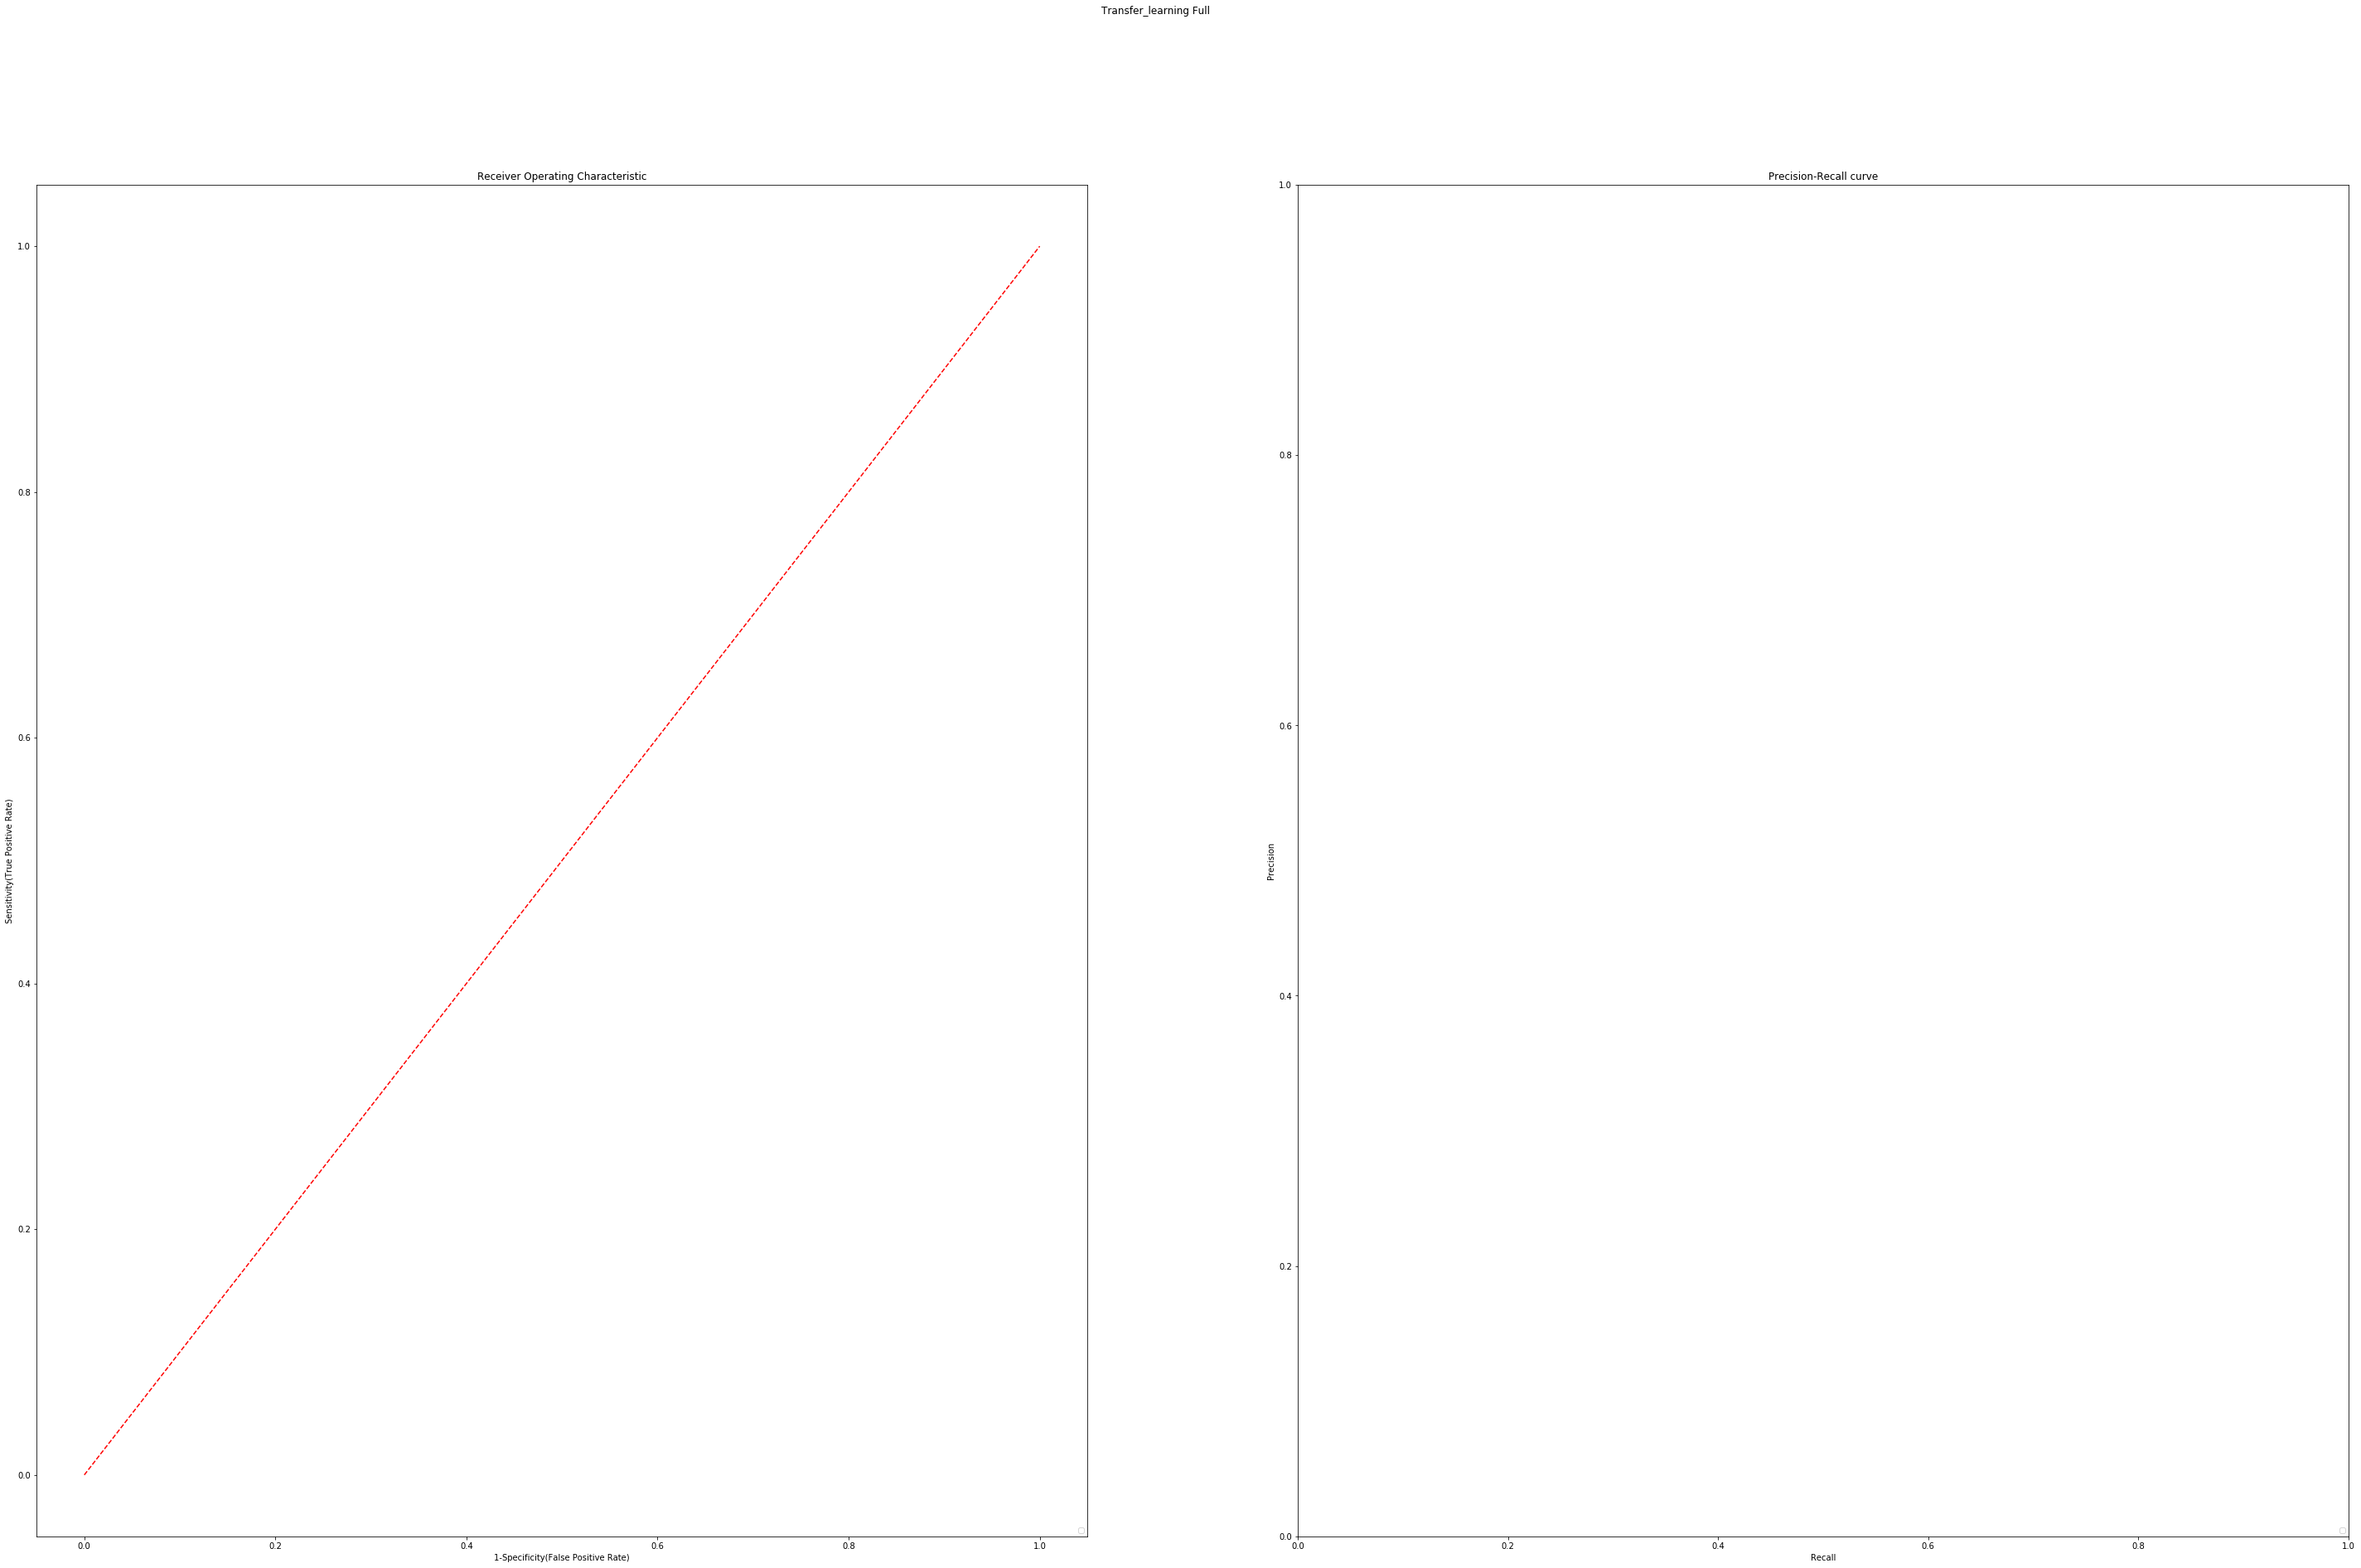

In [7]:
#for tissue in tissues_list:
from time import gmtime, strftime
tissues_list = Transfer_Data_set['Tissue'].unique().tolist()
# tissues_list = ['Testis', 'Whole Blood', 'brain']

def transfear_learning_tissue(tissue):
    results_dict = {'Tissue':[], 'Method':[], 'PR_AUC':[], 'ROC_AUC':[]}
    
    print('------------------', tissue, '-----------------------')

    pathogenic_proportion = Transfer_Data_set[Transfer_Data_set['Tissue'] == tissue]['Pathogenic_Mutation'].value_counts(normalize=True)[True]
    print('Pathogenic_proportion: ', pathogenic_proportion)

    Tissue_data = Transfer_Data_set[Transfer_Data_set['Tissue'] == tissue]
    Other_tissues_data = Transfer_Data_set[Transfer_Data_set['Tissue'] != tissue]
    model = RandomForestClassifier(random_state=1234)
    model.fit(Other_tissues_data[relevant_cols], Other_tissues_data['Pathogenic_Mutation'])

    y_pred = model.predict(Tissue_data[relevant_cols])  # predict the test data
    predictions_proba = model.predict_proba(Tissue_data[relevant_cols])
    pred_true = predictions_proba[:, 1]
    prec, recall, _ = precision_recall_curve(Tissue_data['Pathogenic_Mutation'], pred_true)  # pred[:, 1], pos_label=model.classes_[1]
    fpr, tpr, _ = roc_curve(Tissue_data['Pathogenic_Mutation'], pred_true)
    pr_auc1 = metrics.auc(recall, prec)#average_precision_score(Tissue_data['Pathogenic_Mutation'], pred_true)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC = ', roc_auc)
    print('PR_AUC = ', pr_auc1)
    print('\n')

    # ax2.plot(recall, prec, label='%s PR-AUC = %0.2f' % (tissue, pr_auc1))
    # ax1.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (tissue, roc_auc))

    ax2.plot(recall, prec, label='%s TRACEvar: Proportion = %0.2f, PR-AUC (area = %0.2f)' % (tissue, pathogenic_proportion, pr_auc1),
             color=colors[tissues_list.index(tissue)])
    ax1.plot(fpr, tpr, label='%s TRACEvar: Proportion = %0.2f, ROC (area = %0.2f)' % (tissue, pathogenic_proportion, roc_auc),
             color=colors[tissues_list.index(tissue)])
    "--------------------------- CADD Comparision -------------------------------"

    Tissue_data['PHRED_percent'] = Tissue_data['CADD | Pathogenic score (PHRED)'].apply(lambda x: x * 0.01)
    Precision_Recall, average_precision, ROC, AUC = cadd_as_score_measurements(Tissue_data['CADD | Pathogenic score (PHRED)'], Tissue_data['Pathogenic_Mutation'])
    ax2.plot(Precision_Recall[:, 0], Precision_Recall[:, 1], 'r--', color=colors[tissues_list.index(tissue)],
             label='%s CADD: Proportion = %0.2f, PR-AUC (area = %0.2f)' % (tissue, pathogenic_proportion, average_precision))
    ax1.plot(ROC[:, 0], ROC[:, 1], 'r--', color=colors[tissues_list.index(tissue)],
             label='%s CADD: Proportion = %0.2f, ROC (area = %0.2f)' % (tissue, pathogenic_proportion, AUC))

  
    
    "---------------------------- Results Record ----------------------------"
    
    results_dict['Tissue'].append(tissue)
    results_dict['Method'].append('TRACEvar')
    results_dict['PR_AUC'].append(pr_auc1)
    results_dict['ROC_AUC'].append(roc_auc)
    
    results_dict['Tissue'].append(tissue)
    results_dict['Method'].append('CADD')
    results_dict['PR_AUC'].append(average_precision)
    results_dict['ROC_AUC'].append(AUC)
    
    results_dict['Tissue'].append(tissue)
    results_dict['Method'].append('Pathogenic_proportion')
    results_dict['PR_AUC'].append(pathogenic_proportion)
    results_dict['ROC_AUC'].append(0.5)
    
    Results_df = pd.DataFrame.from_dict(results_dict, orient='columns')
    
    return tissue, strftime("%Y-%m-%d %H:%M:%S", gmtime()), Results_df




def driver_func_shap():
    PROCESSES = 22
    results_df_list = []

    with mp.Pool(PROCESSES) as pool:
        results = [pool.apply_async(transfear_learning_tissue, (tissue,)) for tissue in tissues_list]

        for r in results:
            
            results_tuple = r.get(timeout=None)
            print('@', results_tuple[0], ' finished', results_tuple[1])
            results_df_list.append(results_tuple[2])
            
    All_Results = pd.concat(results_df_list)
    path = os.path.join('..', '..', 'Output', 'Transfer_learning_hg37_ALL_Results_New.csv')
    All_Results.to_csv(path)

    ax1.plot([0, 1], [0, 1], 'r--')
    ax1.set_xlabel('1-Specificity(False Positive Rate)')
    ax1.set_ylabel('Sensitivity(True Positive Rate)')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right", fontsize='small')

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall curve')
    ax2.legend(loc="lower right", fontsize='small')
    fig.suptitle('Transfer_learning Full')
    path = os.path.join('..', '..', 'Output', 'Transfer_learning_hg37_ALL_New.pdf')
    plt.savefig(path)
    
if __name__ == '__main__':
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 30))

    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    driver_func_shap() 
    











# plt.show()


In [ ]:
'-------------------- SHAP Importance ---------------------------'
import shap

Pathogenic = Transfer_Data_set[Transfer_Data_set['Pathogenic_Mutation'] == True]
counts = len(Pathogenic)
folds = 9
Non_pathogenic = Transfer_Data_set[Transfer_Data_set['Pathogenic_Mutation'] == False].sample(n=counts * folds, axis='index', random_state=1234)
Synthetic_Dataset = pd.concat([Pathogenic, Non_pathogenic])
print(Synthetic_Dataset)

model = RandomForestClassifier(random_state=1234)
model.fit(Synthetic_Dataset[relevant_cols], Synthetic_Dataset['Pathogenic_Mutation'])
print('@ Model trained')

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Synthetic_Dataset[relevant_cols])
print('@ Explainer created')

shap.summary_plot(shap_values, Synthetic_Dataset[relevant_cols], plot_type="bar", show=False)
print('@ Plot created')

path = os.path.join('..', '..', 'Output', 'Transfer_learning_hg37_SHAP.pdf')
plt.savefig(path)